In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext kedro.extras.extensions.ipython
%reload_kedro

The kedro.extras.extensions.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.extras.extensions.ipython


In [3]:
from mlsaft.extras.utils.pcsaft import create_pcsaft_parameters_from_gc
from mlsaft.extras.kedro_datasets.checkpoint_dataset import concat_partitioned_dfs
from mlsaft.extras.utils.plotting import parity_plot
from mlsaft.extras.utils.metrics import calculate_metrics
from mlsaft.extras.utils.data_transform import remove_outliers
from mlsaft.extras.utils.doe import generate_search
from mlsaft.pipelines.train_models.models import pcsaft_emulator as emul
from mlsaft.pipelines.train_models.nodes import train_pytorch_lightning, random_split
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import spearmanr, linregress
from scipy.interpolate import griddata
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from feos.eos import EquationOfState, State
from feos import pcsaft,si
from tqdm import tqdm
import torch
from torch import nn

## How much critical temperature data do we have?

tl;dr not much but it seems we don't actually need it as input. We can use a model to learn PCP-SAFT's prediction of the critical temperature and pressure.

In [4]:
partitions = catalog.load("dortmund.pure_component")

2023-03-28 13:56:30,899 - kedro.io.data_catalog - INFO - Loading data from 'dortmund.pure_component' (PartitionedDataSet)...


In [5]:
dfs = []
for partition, df_func in partitions.items():
    if "critical" not in partition:
        continue
    df = df_func()
    df = df.dropna(subset=["T", "P"])
    df = df[["T", "P", "#DDB", "Component"]]
    dfs.append(df)
crit_df = pd.concat(dfs)
crit_df["id"] = crit_df["#DDB"].astype(int)
crit_df = crit_df.set_index("id")
crit_df.head()

,T,P,#DDB,Component
id,,,,
218,421.85,2040.0,218.0,Perfluoropentane
466,451.65,1910.0,466.0,Perfluorohexane
303,477.75,1750.0,303.0,Perfluoro-n-heptane
3901,502.25,1660.0,3901.0,Perfluoro-n-octane
1914,523.95,1560.0,1914.0,Perfluorononane


In [6]:
smiles_lookup = catalog.load("dortmund.smiles_lookup_classified_merged")
smiles_lookup = smiles_lookup.reset_index()
smiles_lookup["id"] = smiles_lookup["id"].astype(float).astype(int)
smiles_lookup.head()

2023-03-28 13:45:03,200 - kedro.io.data_catalog - INFO - Loading data from 'dortmund.smiles_lookup_classified_merged' (ParquetDataSet)...


,id,smiles,cas_number,name,alternative_name
0,13,C1CO1,None,None,None
1,143,CC1CO1,None,None,None
2,84,CC(=O)O,None,None,None
3,15,O=CO,None,None,None
4,4,CC(C)=O,None,None,None


In [7]:
crit_df.merge(smiles_lookup, on="id").head()

,id,T,P,#DDB,Component,smiles,cas_number,name,alternative_name
0,218,421.85,2040.0,218.0,Perfluoropentane,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,None,None,None
1,218,420.59,2045.0,218.0,Perfluoropentane,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,None,None,None
2,218,420.59,2045.0,218.0,Perfluoropentane,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,None,None,None
3,466,451.65,1910.0,466.0,Perfluorohexane,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,None,None,None
4,466,447.65,1620.0,466.0,Perfluorohexane,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,None,None,None


## Training PCP-SAFT 

### Critical points

We first need to generate data for $P*$ and $T^*$. I'll use a quasi random design to generate input values for the six PCP-SAFT parameters. Some of these will not converge.

Then I'll train a neural network to predict $P*$ and $T^*$ as well as a classifier for whether or not the critical point calculation wold converge.

In [4]:
parameters_df = catalog.load("pcp_saft_sepp_pure_parameters")

2023-03-28 14:00:12,979 - kedro.io.data_catalog - INFO - Loading data from 'pcp_saft_sepp_pure_parameters' (CSVDataSet)...


In [25]:
# Generate quasi random design
space = {
    "m": {"min": 0.5, "max": 5.0, "scaling": "linear", "type": float},
    "sigma": {"min": 0.5, "max": 5.0, "scaling": "linear", "type": float},
    "epsilon_k": {"min": 100.0, "max": 1000., "scaling": "linear","type": float},
    "mu": {"min": 0, "max": 3.0, "scaling": "linear","type": float},
    "epsilonAB": {"min": 100.0, "max": 4000., "scaling": "linear","type": float},
    "KAB": {"min": 0.0001, "max": 4.0, "scaling": "log","type": float},
}
# Need to make space balancd betwween associating and non-associating
search = generate_search(space, num_trials=1000)
search_df = pd.DataFrame(search)
search_df_non_associating = search_df.copy()
search_df_non_associating["epsilonAB"] = 0.
search_df_non_associating["KAB"] = 0.
search_df = pd.concat([search_df, search_df_non_associating], axis=0).reset_index(drop=True)

In [26]:
# Create FeOs PCP-SAFT parameters
feos_parameters = []
for i, row in search_df.iterrows():
    identifier = pcsaft.Identifier()
    psr = pcsaft.PcSaftRecord(
        m=row["m"],
        sigma=row["sigma"],
        epsilon_k=row["epsilon_k"],
        mu=row["mu"],
        kappa_ab=row["KAB"],
        epsilon_k_ab=row["epsilonAB"],
    )
    mw = 100 # Molecular weight only used for mass density calculation
    record = pcsaft.PureRecord(identifier, molarweight=mw, model_record=psr)
    parameters = pcsaft.PcSaftParameters.new_pure(record)
    feos_parameters.append(parameters)

In [ ]:
# Predict critical points using PCP-SAFT
critical_points = []
for parameters in tqdm(feos_parameters):
    eos = EquationOfState.pcsaft(parameters)
    try:
        critical_point = State.critical_point(eos)
        critical_temperature = critical_point.temperature / si.KELVIN
        critical_pressure = critical_point.pressure() * 1e3  / si.PASCAL
    except RuntimeError:
        critical_temperature = None
        critical_pressure = None
    critical_points.append([critical_temperature,critical_pressure])
crit_df = pd.DataFrame(critical_points, columns=["T_crit", "P_crit"])
crit_df = pd.concat([search_df, crit_df], axis=1).reset_index(drop=True)

# Clip values
crit_df["T_crit"] = crit_df["T_crit"].clip(0, 1e4)
crit_df["P_crit"] = crit_df["P_crit"].clip(-1e4, 1e4)

# Set negative pressures as non-converged
neg_pressure = crit_df["P_crit"] < 0
crit_df.loc[neg_pressure, "P_crit"] = None

# Identify failed calculations
crit_df["converged"] = True
successful = crit_df["P_crit"].isna()
crit_df.loc[successful, "converged"] = False

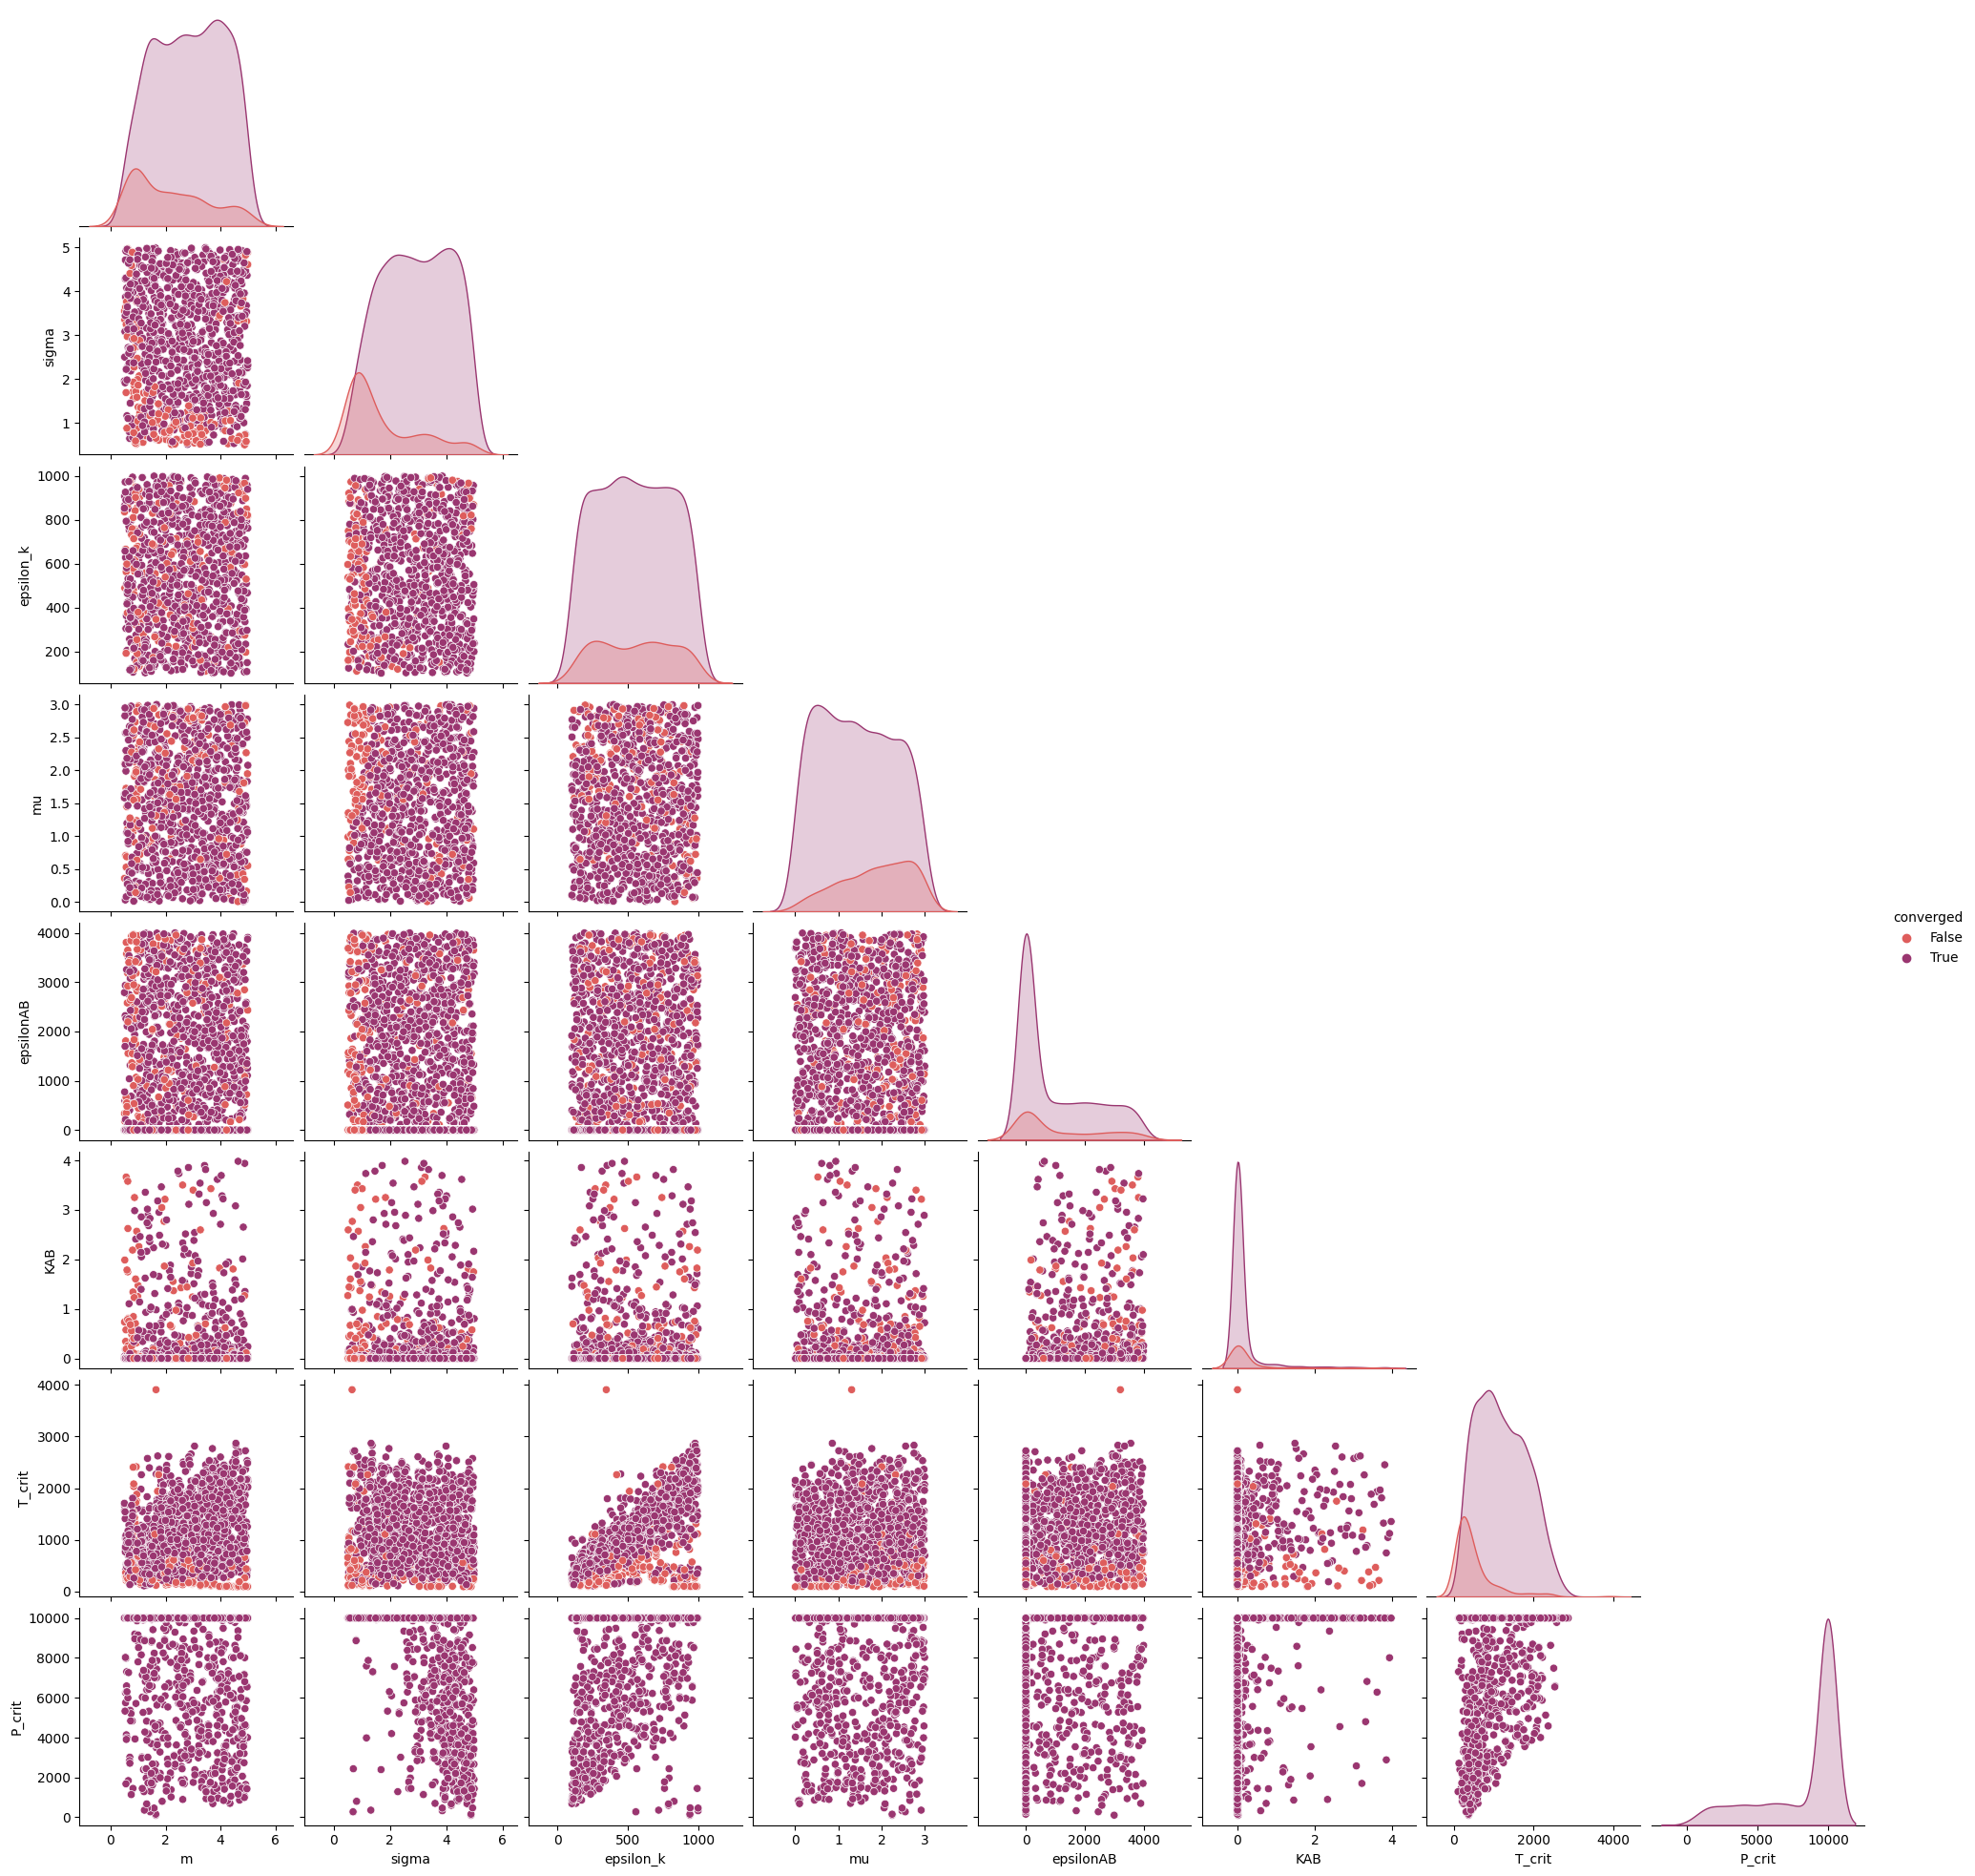

In [28]:
g = sns.pairplot(crit_df, hue="converged", corner=True, palette="flare")
g.savefig("../data/08_reporting/pairplot_critical_points.png", dpi=300)
g.figure

In [14]:
crit_df["converged"].value_counts()

True     12677
False     2323
Name: converged, dtype: int64

### Phase Equilibria

In [13]:
phase_df = catalog.load("pcsaft_emulator_phase_equilibria")

2023-03-28 23:54:16,458 - kedro.io.data_catalog - INFO - Loading data from 'pcsaft_emulator_phase_equilibria' (ParquetDataSet)...


In [14]:
phase_df.isna().any(axis=0)

T             False
P             False
rho_l         False
rho_v         False
m             False
sigma         False
epsilon_k     False
mu            False
epsilonAB     False
KAB           False
inverse_T     False
Tr            False
inverse_Tr    False
log_Tr        False
Pr            False
log_Pr        False
rho_l_s       False
rho_v_s       False
failed        False
dtype: bool

In [12]:
phase_df["P"].min()

-3589439.778588682